# Modelling the behavior of a mass-on-spring system

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import seed, random
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(1337)  # for reproducibility

data = pd.read_csv("SpringData.csv", na_filter=False)

# The first 5 rows of the csv
print(data.head(5))

   VideoAnalysis: Time (s)  VideoAnalysis: X  VideoAnalysis: Y  \
0                 0.000000         -1.054688          0.222656   
1                 0.033367         -1.445312        -13.539062   
2                 0.066733         -1.054688        -36.414062   
3                 0.100100          0.375000        -51.472656   
4                 0.133467         -1.750000        -64.359375   

   VideoAnalysis: X Velocity  VideoAnalysis: Y Velocity  
0                  -3.473089                -475.292936  
1                   3.892592                -527.293345  
2                  13.162619                -515.316715  
3                  -1.118673                -407.544929  
4                  -1.908898                -261.291443  


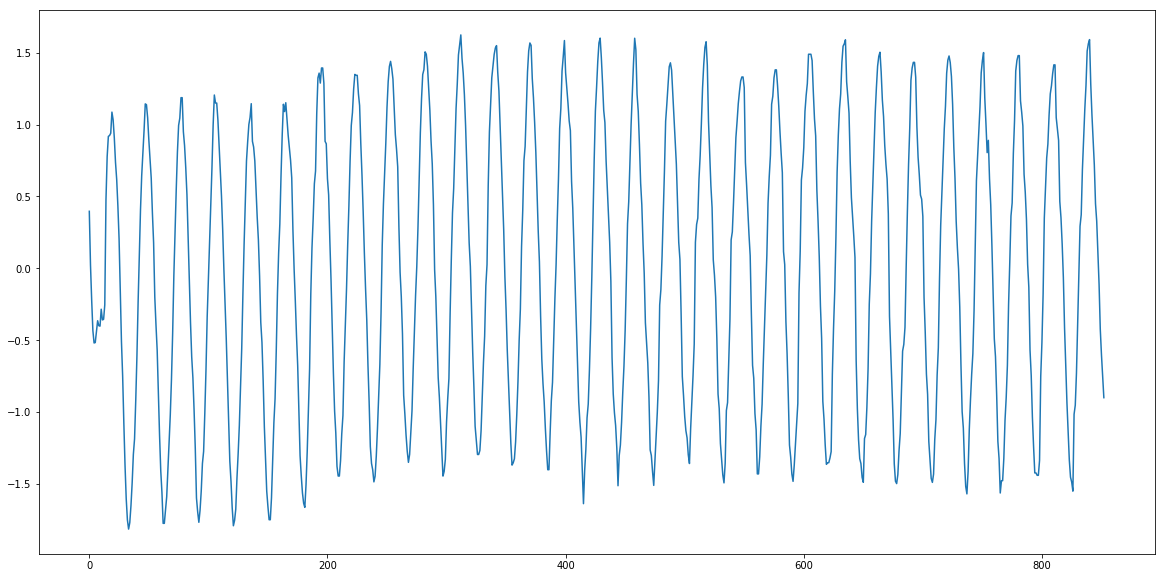

In [3]:
window = 1
edge = int(np.ceil(window/2))

def preprocess(data):
    # Calculate the moving average
    data = data.rolling(window=window,center=True).mean()
    # Trim the data that wasn't part of the moving average
    data = data[edge:-edge]
    # Standardize the data
    return preprocessing.scale(data) 

t = data["VideoAnalysis: Time (s)"][edge:-edge]
X_data = preprocess(data["VideoAnalysis: X"])
Y_data = preprocess(data["VideoAnalysis: Y"])

plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(Y_data)

In [4]:
def _load_data(data, n_prev = 120):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(pd.DataFrame(Y_data), 0.3)

In [5]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Train on 429 samples, validate on 48 samples
Epoch 1/100


UnknownError: Fail to find the dnn implementation.
	 [[Node: bidirectional_1/CudnnRNN = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_1/transpose, bidirectional_1/ExpandDims_1, bidirectional_1/ExpandDims_2, bidirectional_1/concat)]]
	 [[Node: loss/mul/_115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1204_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'bidirectional_1/CudnnRNN', defined at:
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-a8bbe6487235>", line 3, in <module>
    model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False), input_shape=(None, 1)))
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py", line 467, in add
    layer(x)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/wrappers.py", line 324, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/wrappers.py", line 384, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 510, in _process_batch
    is_training=True)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1480, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1371, in __call__
    seed=self._seed)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 860, in _cudnn_rnn
    name=name)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/ops/gen_cudnn_rnn_ops.py", line 110, in cudnn_rnn
    is_training=is_training, name=name)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

UnknownError (see above for traceback): Fail to find the dnn implementation.
	 [[Node: bidirectional_1/CudnnRNN = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_1/transpose, bidirectional_1/ExpandDims_1, bidirectional_1/ExpandDims_2, bidirectional_1/concat)]]
	 [[Node: loss/mul/_115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1204_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# evaluate model fit
print(X_test.shape)
score = model.evaluate(X_test, y_test)
print('Test score:', score)

In [ ]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()